In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import bernoulli
from scipy.stats import beta
import random

In [2]:
def uniform_bandit(K,N,T,p):
    #explore
    reward = np.zeros(K)
    cumreward = []
    means = []
    max_ind = np.argmax(p)
    for i in range(K):
        for j in range(N):
            r =  bernoulli.rvs(p[i])
            reward[i] += r
            cumreward.append(r)
            means.append(p[i])
        reward[i] /= N
        
    max_arm = np.argmax(reward)
    for i in range(T-K*N):
        cumreward.append(bernoulli.rvs(p[max_arm]))
        means.append(p[max_arm])
    return cumreward,means

def eps_greedy(K,T,p):
    #explore
    reward = np.zeros(K)
    avgreward = np.zeros(K)
    n = np.zeros(K)
    
    cumreward = []
    means = []
    max_ind = np.argmax(p)
        
    for i in range(T):
        eps = (i+1)**(-1/3) *0.5
        #print(eps)
        coin = bernoulli.rvs(min(eps,1))
        if coin == 1:
            tmp_ind = random.randint(0,K-1)
            r = bernoulli.rvs(p[tmp_ind])
            cumreward.append(r)
            means.append(p[tmp_ind])
            reward[tmp_ind] += r
            n[tmp_ind] +=1
            avgreward[tmp_ind] = reward[tmp_ind]/n[tmp_ind]
        else:
            tmp_ind = np.argmax(avgreward)
            r = bernoulli.rvs(p[tmp_ind])
            reward[tmp_ind] += r
            n[tmp_ind] +=1
            avgreward[tmp_ind] = reward[tmp_ind]/n[tmp_ind]
 
            cumreward.append(r)
            means.append(p[tmp_ind])
            
    return cumreward,means

#successive elimination

def successive_elimination(K,T,p):

    reward = np.zeros(K)
    avgreward = np.zeros(K)
    n = np.zeros(K)
    actives = np.ones(K)
    cumreward = []
    means = []
    max_ind = np.argmax(p)
    t = 0
    while t < T:
        indices = np.where(actives==1)[0]
        #print(indices)
        for i in range(len(indices)):
            tmp_ind = indices[i]

            for j in range(100):
                r = bernoulli.rvs(p[tmp_ind])
                cumreward.append(r)
                means.append(p[tmp_ind])
                reward[tmp_ind] += r
                n[tmp_ind] +=1
                avgreward[tmp_ind] = reward[tmp_ind]/n[tmp_ind]
                t+=1
        #print(avgreward)
        UCBS = avgreward + np.sqrt(2*np.log(T)/n)
        LCBS = avgreward - np.sqrt(2*np.log(T)/n)
        
        #actucb = UCBS[indices]
        actlcb = LCBS[indices]
        max_lcb = np.max(actlcb)
        #print(actucb)
        #print(actlcb)
        for k in range(len(indices)):
            if UCBS[indices[k]] < max_lcb:
                actives[indices[k]] = 0
    return cumreward,means

#successive elimination

def UCB1(K,T,p):

    reward = np.zeros(K)
    avgreward = np.zeros(K)
    n = np.zeros(K)
    cumreward = []
    means = []
    #max_ind = np.argmax(p)
    t = 0
    for i in range(K):
        r = bernoulli.rvs(p[i])
        cumreward.append(r)
        means.append(p[i])
        reward[i] += r
        n[i] +=1
        avgreward[i] = reward[i]/n[i]
        t+=1
        
    while t < T:
        
        UCBS = avgreward + np.sqrt(2*np.log(T)/n)
        id_max = np.argmax(UCBS)
        r = bernoulli.rvs(p[id_max])
        means.append(p[id_max])
        cumreward.append(r)
        reward[id_max] += r
        n[id_max] +=1
        avgreward[id_max] = reward[id_max]/n[id_max]
        t+=1
        
        
    return cumreward,means

def TS(K,T,p):
    reward = np.zeros(K)
    avgreward = np.zeros(K)
    n = np.zeros(K)
    cumreward = []
    means = []
    alphas = np.ones(K)*0.5
    betas = np.ones(K)*0.5
    for t in range(T):
        sample = beta.rvs(alphas,betas)
        max_ind = np.argmax(sample)
        r = bernoulli.rvs(p[max_ind])
        means.append(p[max_ind])
        reward[max_ind]+=r
        n[max_ind]+=1
        avgreward[max_ind]+=reward[max_ind]/n[max_ind]
        
        alphas[max_ind]+=r
        betas[max_ind]+= (1-r)
        cumreward.append(r)
    return cumreward,means

In [3]:
def plotter(a,b,max_p):
    a = np.array(a)
    b = np.array(b)

    plt.figure()
    xplot = range(1,len(a)+1)
    cum_reward = np.cumsum(a)
    cum_mean = np.cumsum(b)
    plt.scatter(xplot,cum_reward/xplot,s=5,c ='#4C72B0',label='average return')
    plt.scatter(xplot,cum_mean/xplot,s=5,c ='#DD8452',label='average return')
    plt.legend()

    plt.figure()
    plt.scatter(xplot,max_p - cum_reward/xplot,c ='#4C72B0',s=5,label='expected regret')
    plt.scatter(xplot,max_p - cum_mean/xplot,c='#DD8452',s=5,label='average regret')
    plt.legend()

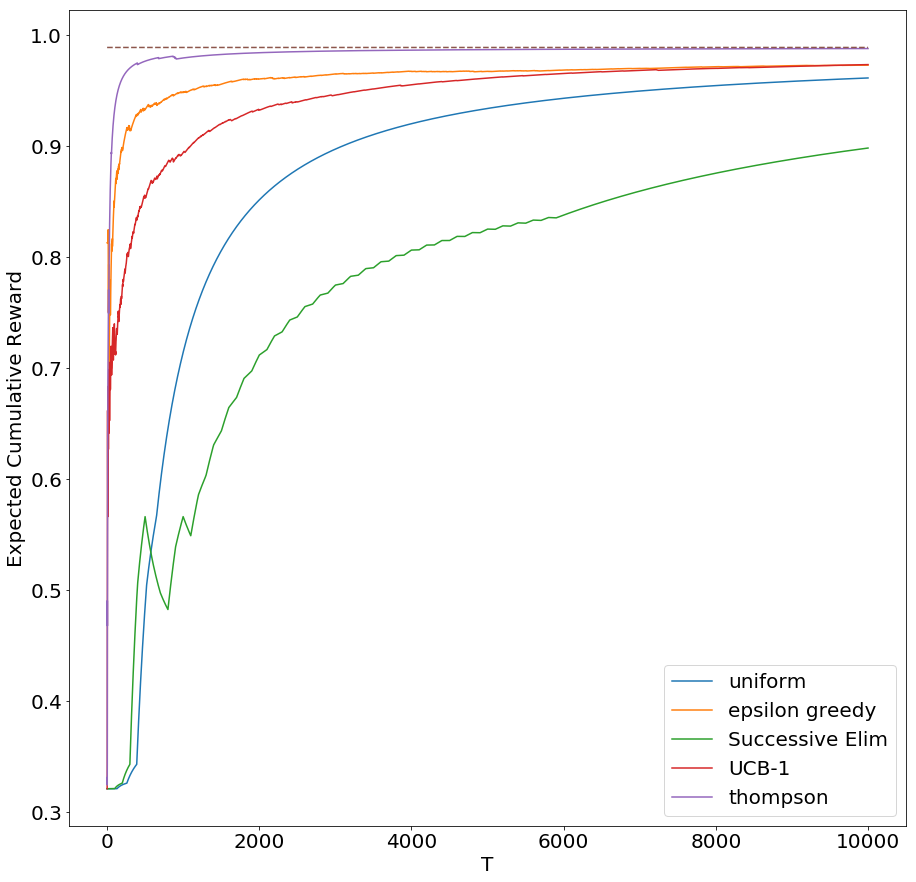

In [19]:
iters = 10000
p =np.random.rand(5)
K = len(p)
max_p = np.max(p)

a,ba = uniform_bandit(K,130,iters,p)
c,bb = eps_greedy(K,iters,p)
d,bc = successive_elimination(K,iters,p)
e,bd = UCB1(K,iters,p)
f,be = TS(K,iters,p)

rt = [ba,bb,bc,bd,be]
labs = ['uniform','epsilon greedy','Successive Elim','UCB-1','thompson']
plt.figure(figsize=(15,15))

for i in range(len(rt)):

    a = np.array(rt[i])
    xplot = range(1,len(a)+1)
    cum_reward = np.cumsum(a)
    plt.plot(xplot,cum_reward/xplot,label=labs[i])
fs = 20    
plt.legend(fontsize=fs)
plt.plot(xplot,max_p*np.ones(len(xplot)),'--')

plt.xticks(fontsize=fs)
plt.xlabel("T",fontsize=fs)
plt.ylabel('Expected Cumulative Reward',fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('fig0.pdf',bbox_inches='tight')

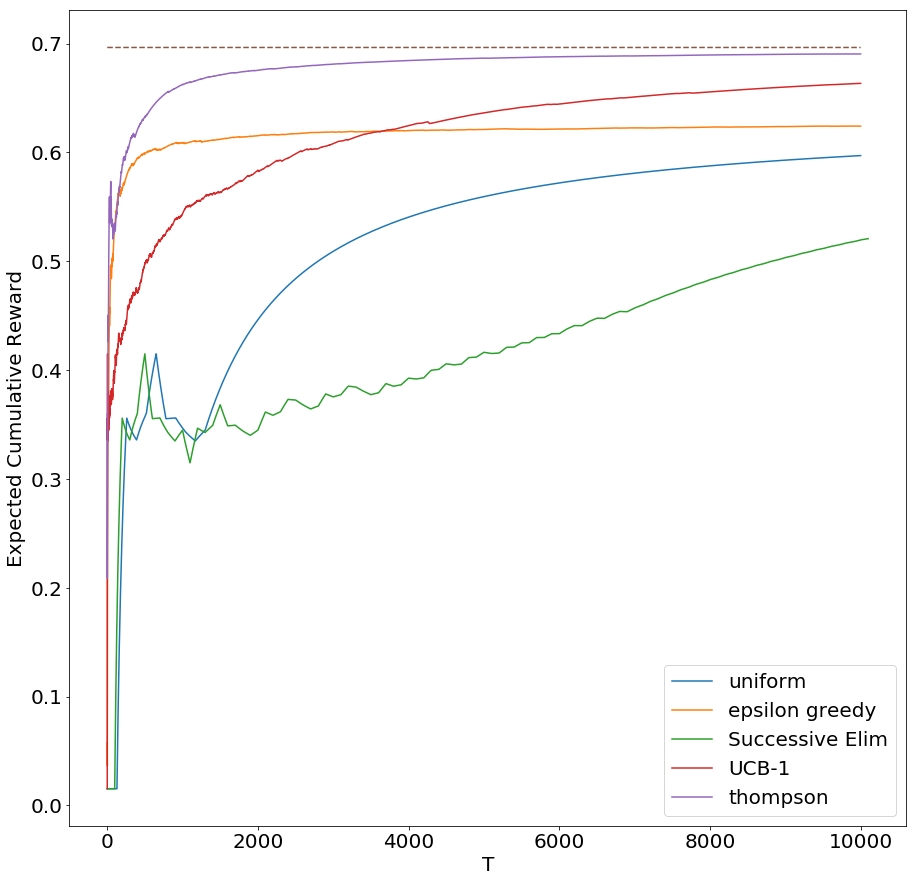

In [20]:
iters = 10000
p =np.random.rand(10)
K = len(p)
max_p = np.max(p)

a,ba = uniform_bandit(K,130,iters,p)
c,bb = eps_greedy(K,iters,p)
d,bc = successive_elimination(K,iters,p)
e,bd = UCB1(K,iters,p)
f,be = TS(K,iters,p)

rt = [ba,bb,bc,bd,be]
labs = ['uniform','epsilon greedy','Successive Elim','UCB-1','thompson']
plt.figure(figsize=(15,15))

for i in range(len(rt)):
    a = np.array(rt[i])
    xplot = range(1,len(a)+1)
    cum_reward = np.cumsum(a)
    plt.plot(xplot,cum_reward/xplot,label=labs[i])
fs = 20    
plt.legend(fontsize=fs)
plt.plot(xplot,max_p*np.ones(len(xplot)),'--')

plt.xticks(fontsize=fs)
plt.xlabel("T",fontsize=fs)
plt.ylabel('Expected Cumulative Reward',fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('fig1.pdf',bbox_inches='tight')

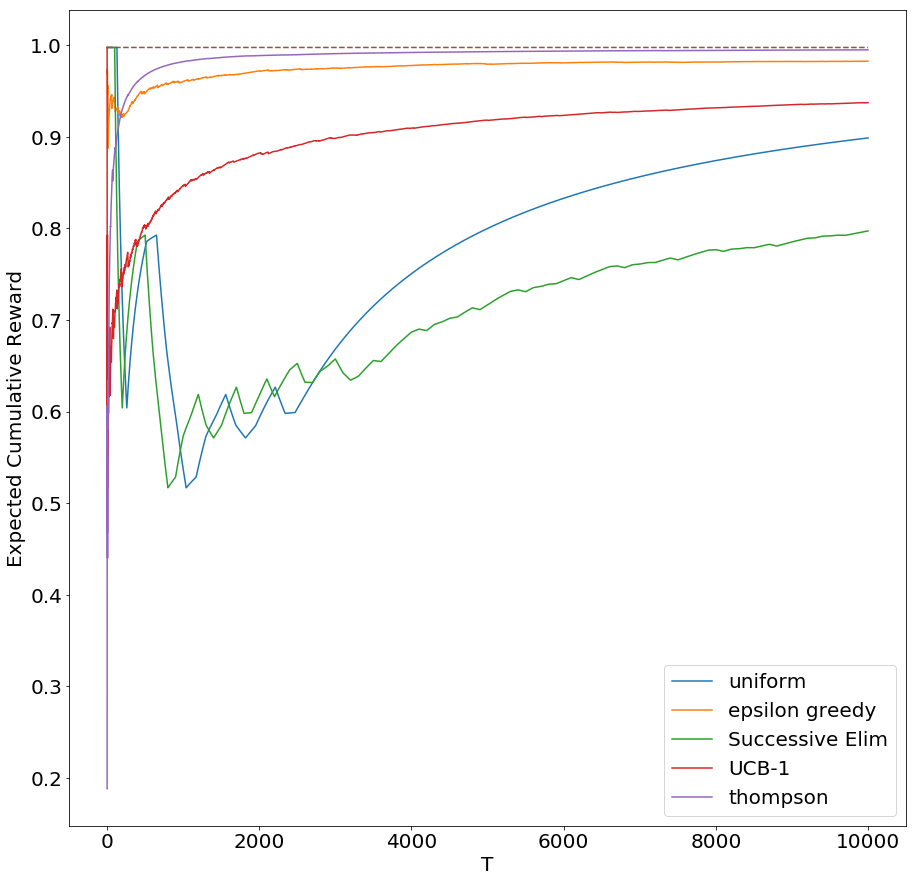

In [22]:
iters = 10000
p =np.random.rand(20)
K = len(p)
max_p = np.max(p)

a,ba = uniform_bandit(K,130,iters,p)
c,bb = eps_greedy(K,iters,p)
d,bc = successive_elimination(K,iters,p)
e,bd = UCB1(K,iters,p)
f,be = TS(K,iters,p)

rt = [ba,bb,bc,bd,be]
labs = ['uniform','epsilon greedy','Successive Elim','UCB-1','thompson']
plt.figure(figsize=(15,15))

for i in range(len(rt)):
    a = np.array(rt[i])
    xplot = range(1,len(a)+1)
    cum_reward = np.cumsum(a)
    plt.plot(xplot,cum_reward/xplot,label=labs[i])
fs = 20    
plt.legend(fontsize=fs)
plt.plot(xplot,max_p*np.ones(len(xplot)),'--')

plt.xticks(fontsize=fs)
plt.xlabel("T",fontsize=fs)
plt.ylabel('Expected Cumulative Reward',fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('fig2.pdf',bbox_inches='tight')

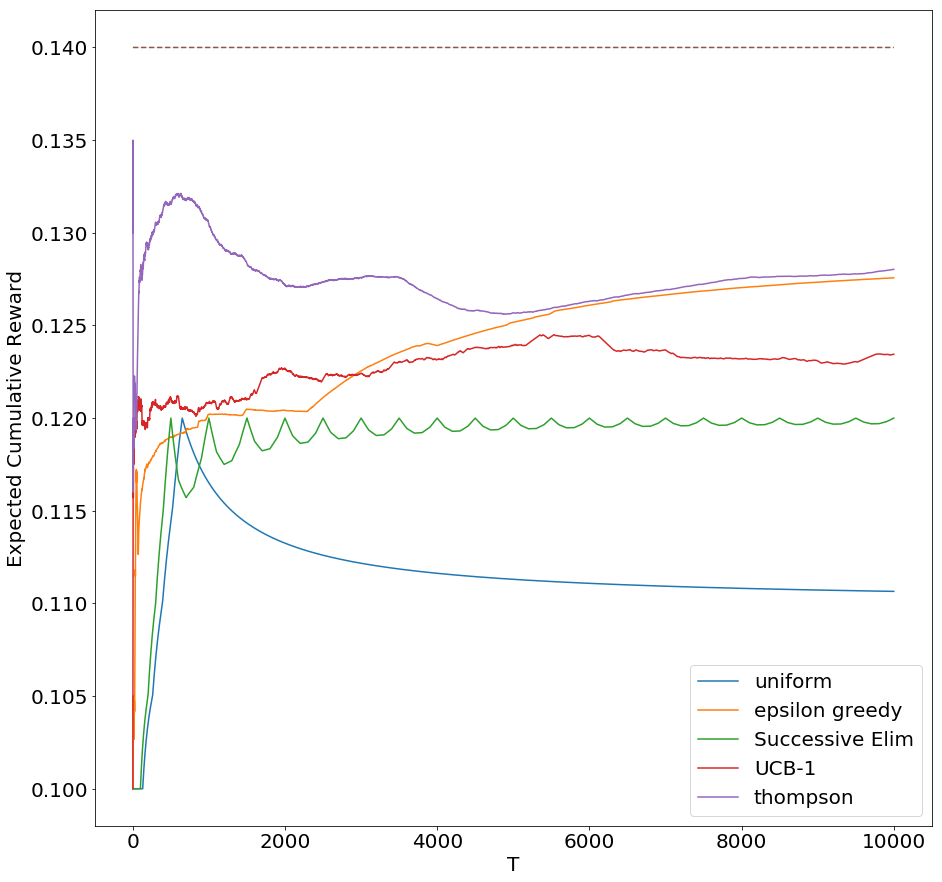

In [23]:
iters = 10000
p =np.array([0.1,0.11,0.12,0.13,0.14])
K = len(p)
max_p = np.max(p)

a,ba = uniform_bandit(K,130,iters,p)
c,bb = eps_greedy(K,iters,p)
d,bc = successive_elimination(K,iters,p)
e,bd = UCB1(K,iters,p)
f,be = TS(K,iters,p)

rt = [ba,bb,bc,bd,be]
labs = ['uniform','epsilon greedy','Successive Elim','UCB-1','thompson']
plt.figure(figsize=(15,15))

for i in range(len(rt)):
    a = np.array(rt[i])
    xplot = range(1,len(a)+1)
    cum_reward = np.cumsum(a)
    plt.plot(xplot,cum_reward/xplot,label=labs[i])
fs = 20    
plt.legend(fontsize=fs)
plt.plot(xplot,max_p*np.ones(len(xplot)),'--')

plt.xticks(fontsize=fs)
plt.xlabel("T",fontsize=fs)
plt.ylabel('Expected Cumulative Reward',fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('fig3.pdf',bbox_inches='tight')

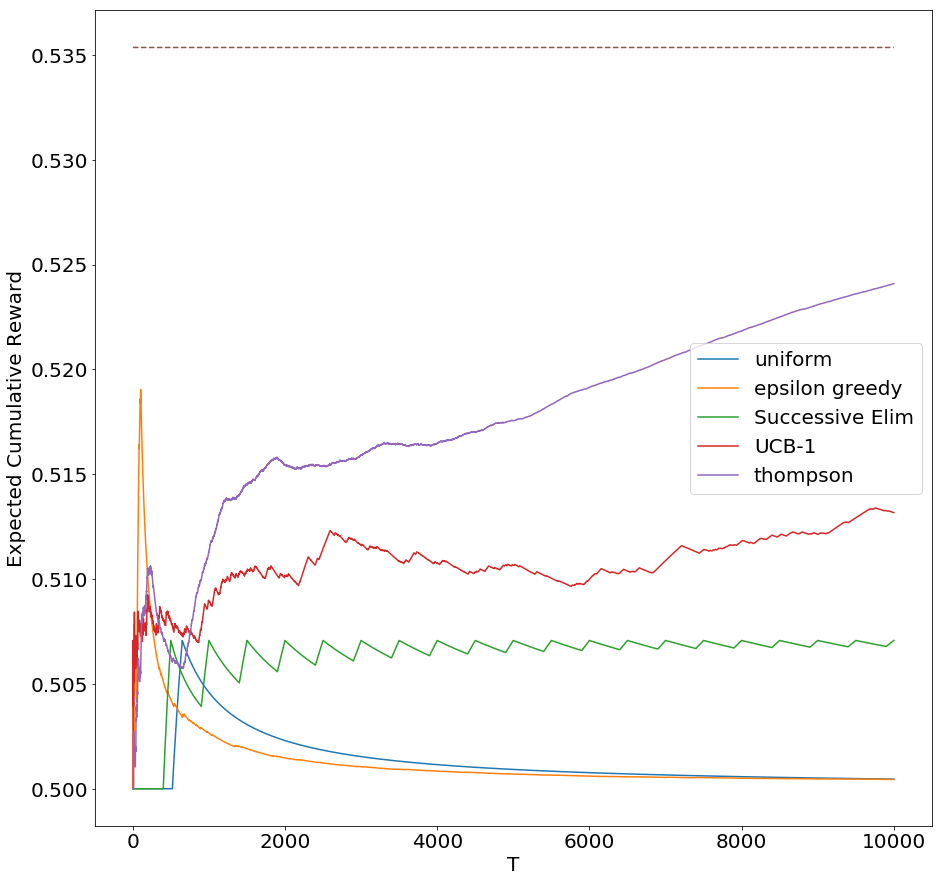

In [24]:
iters = 10000
p =np.array([0.5,0.5,0.5,0.5,(1+5*np.sqrt(2/iters))/2])
K = len(p)
max_p = np.max(p)

a,ba = uniform_bandit(K,130,iters,p)
c,bb = eps_greedy(K,iters,p)
d,bc = successive_elimination(K,iters,p)
e,bd = UCB1(K,iters,p)
f,be = TS(K,iters,p)

rt = [ba,bb,bc,bd,be]
labs = ['uniform','epsilon greedy','Successive Elim','UCB-1','thompson']
plt.figure(figsize=(15,15))

for i in range(len(rt)):
    a = np.array(rt[i])
    xplot = range(1,len(a)+1)
    cum_reward = np.cumsum(a)
    plt.plot(xplot,cum_reward/xplot,label=labs[i])
fs = 20    
plt.legend(fontsize=fs)
plt.plot(xplot,max_p*np.ones(len(xplot)),'--')

plt.xticks(fontsize=fs)
plt.xlabel("T",fontsize=fs)
plt.ylabel('Expected Cumulative Reward',fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('fig4.pdf',bbox_inches='tight')

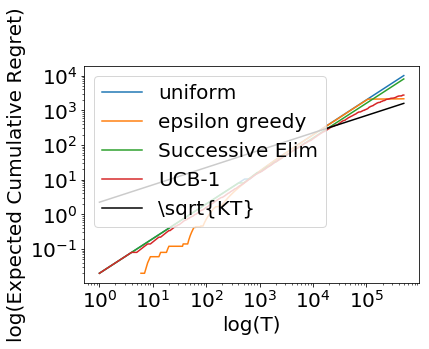

In [25]:
iters = 5*10**5
c = 20
p =np.array([0.5,0.5,0.5,0.5,(1+c*np.sqrt(2/iters))/2])
K = len(p)
#p =np.array([0.1,0.2,0.9,0.5])

max_p = np.max(p)

a,b = uniform_bandit(K,130,iters,p)
c,bb = eps_greedy(K,iters,p)
d,bc = successive_elimination(K,iters,p)
e,bd = UCB1(K,iters,p)

rt = [b,bb,bc,bd]
labs = ['uniform','epsilon greedy','Successive Elim','UCB-1']
plt.figure()


for i in range(len(rt)):
    a = np.array(rt[i])
    xplot = np.arange(1,len(a)+1,1)
    cum_reward = np.cumsum(a)
    plt.loglog(xplot,max_p*xplot-cum_reward,label=labs[i])
plt.loglog(xplot,np.sqrt(K*xplot),color='black',label=r'\sqrt{KT}')

    
fs = 20    
plt.legend(fontsize=fs)
plt.xticks(fontsize=fs)
plt.xlabel("log(T)",fontsize=fs)
plt.ylabel('log(Expected Cumulative Regret)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('fig5.pdf',bbox_inches='tight')


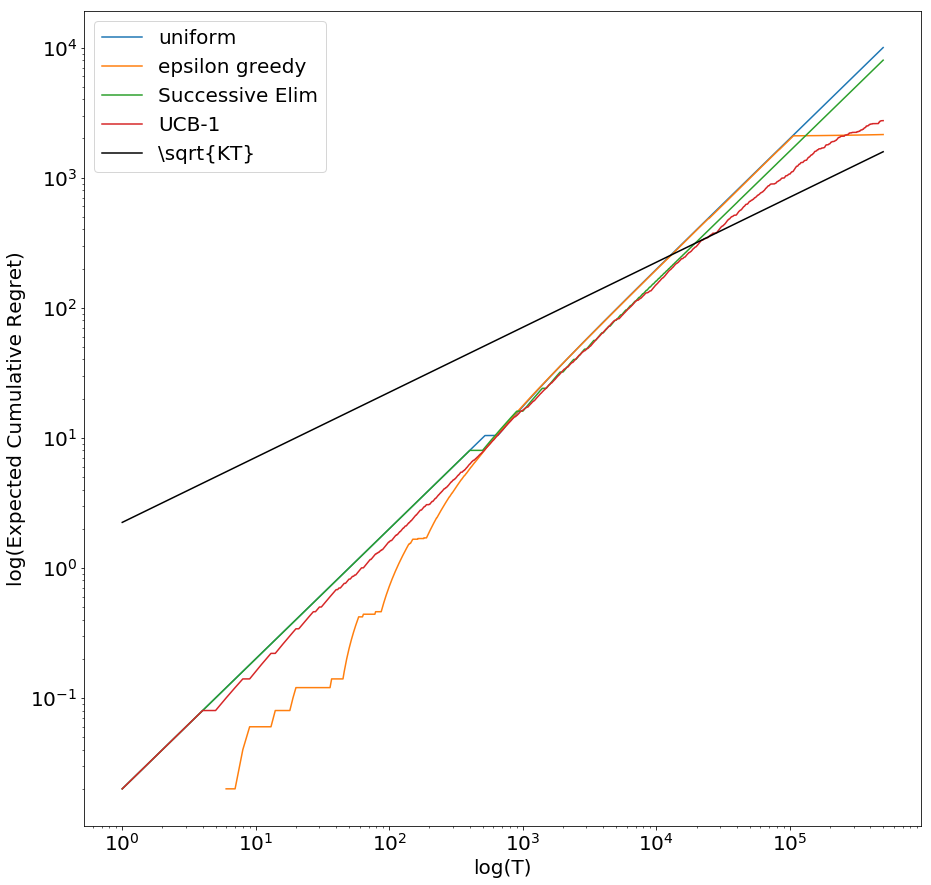

In [26]:
plt.figure(figsize=(15,15))


for i in range(len(rt)):
    a = np.array(rt[i])
    xplot = np.arange(1,len(a)+1,1)
    cum_reward = np.cumsum(a)
    plt.loglog(xplot,max_p*xplot-cum_reward,label=labs[i])
plt.loglog(xplot,np.sqrt(K*xplot),color='black',label=r'\sqrt{KT}')

    
fs = 20    
plt.legend(fontsize=fs)
plt.xticks(fontsize=fs)
plt.xlabel("log(T)",fontsize=fs)
plt.ylabel('log(Expected Cumulative Regret)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('fig5.pdf',bbox_inches='tight')


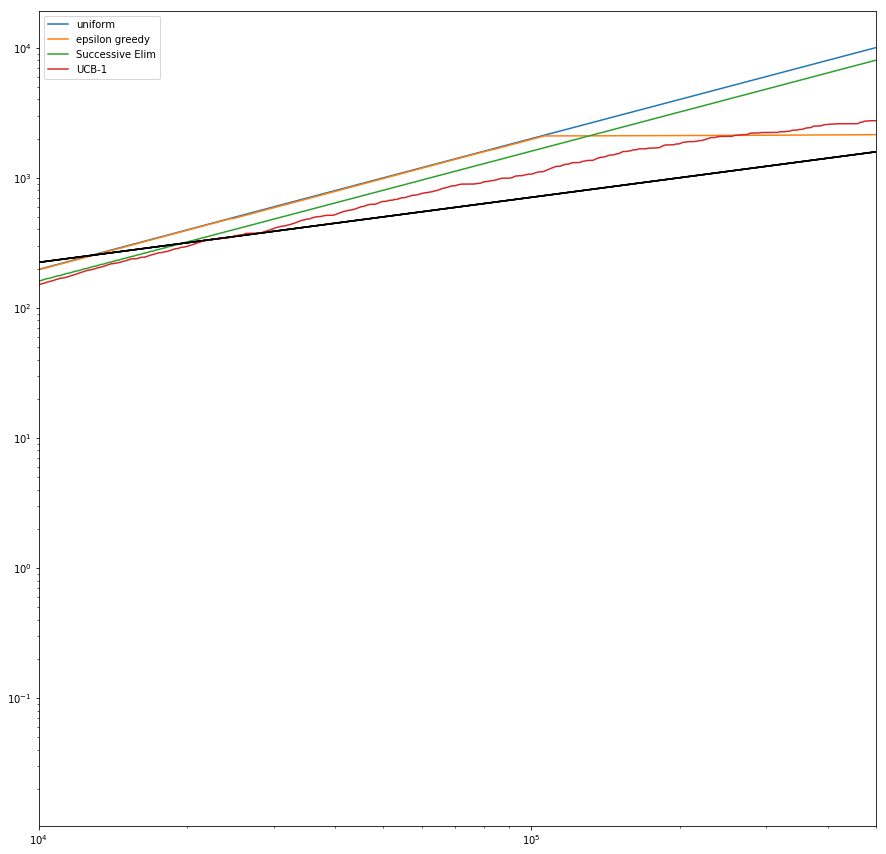

In [27]:
plt.figure(figsize=(15,15))
for i in range(len(rt)):
    a = np.array(rt[i])
    xplot = np.arange(1,len(a)+1,1)
    cum_reward = np.cumsum(a)
    plt.loglog(xplot,max_p*xplot-cum_reward,label=labs[i])
    plt.loglog(xplot,np.sqrt(K*xplot),color='black')
plt.xlim([10000,5*10**5])
plt.legend()

In [77]:
(21-7)/(500)

0.028

In [55]:
(0.0425-0.039)/(1000-200)

4.375000000000004e-06

In [41]:
y2 = np.log(0.5 - np.cumsum(bb)[-1]/1000)

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


In [42]:
y1 = np.log(0.5 - np.cumsum(bb)[-6]/995)

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


In [43]:
np.gradient

nan

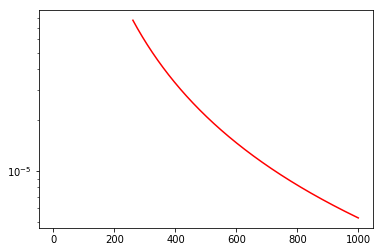

In [30]:
der = np.diff(((max_p - np.cumsum(b))/xplot)) / np.diff(xplot)
x2 = (xplot[:-1] + xplot[1:]) / 2
plt.semilogy(x2, der, 'r')

In [9]:
#adversarial networks

In [98]:
mu1 = [1,0]
mu2 = [0,1]

In [146]:
def uniform_bandit(K,N,T,mu1,mu2,thresh):
    #explore
    reward = np.zeros(K)
    cumreward = []
    means = []
    ctr = 0
    def pfunc(p):
        
        if (ctr%100 ==0):
            if (bernoulli.rvs(thresh) == 1):
                p = mu1
            else:
                p = mu2
        return p
    #max_ind = np.argmax(p)
    p = mu1
    for i in range(K):
        for j in range(N):
            p = pfunc(p)    
            ctr+=1
            r =  bernoulli.rvs(p[i])
            reward[i] += r
            cumreward.append(r)
            means.append(p[i])
        reward[i] /= N
        
    max_arm = np.argmax(reward)
    for i in range(T-K*N):
        p = pfunc(p)
        ctr+=1
        cumreward.append(bernoulli.rvs(p[max_arm]))
        means.append(p[max_arm])
    return cumreward,means


def exp3(gg,K,T,mu1,mu2,thresh):
    reward = np.zeros(K)
    cumreward = []
    means = []
    ctr = 0
    def pfunc(p):
        
        if (ctr%100 ==0):
            if (bernoulli.rvs(thresh) == 1):
                p = mu1
            else:
                p = mu2
        return p
    
    
    w = np.ones(K)
    estim_p = np.zeros(K)
    p = mu1
    for t in range(T):
        p = pfunc(p)
        #print(p)
        ctr+=1
        estim_p = (1-gg)* w/w.sum() + gg/K
        
        idx = draw(estim_p)
        
        r = bernoulli.rvs(p[idx])
        estim_reward = r/estim_p[idx]
        
        w[idx] = w[idx]*np.exp(gg*estim_reward/K)
        
        cumreward.append(r)
        #means.append(p[max_arm]
    return cumreward
import random
def draw(weights):
    choice = random.uniform(0, sum(weights))
    choiceIndex = 0
    #print(choice)
    for weight in weights:
        choice -= weight
        if choice <= 0:
            return choiceIndex

        choiceIndex += 1


In [166]:
a,c = uniform_bandit(2,130,10000,mu1,mu2,0.5)
b = exp3(0.19,2,10000,mu1,mu2,0.5)

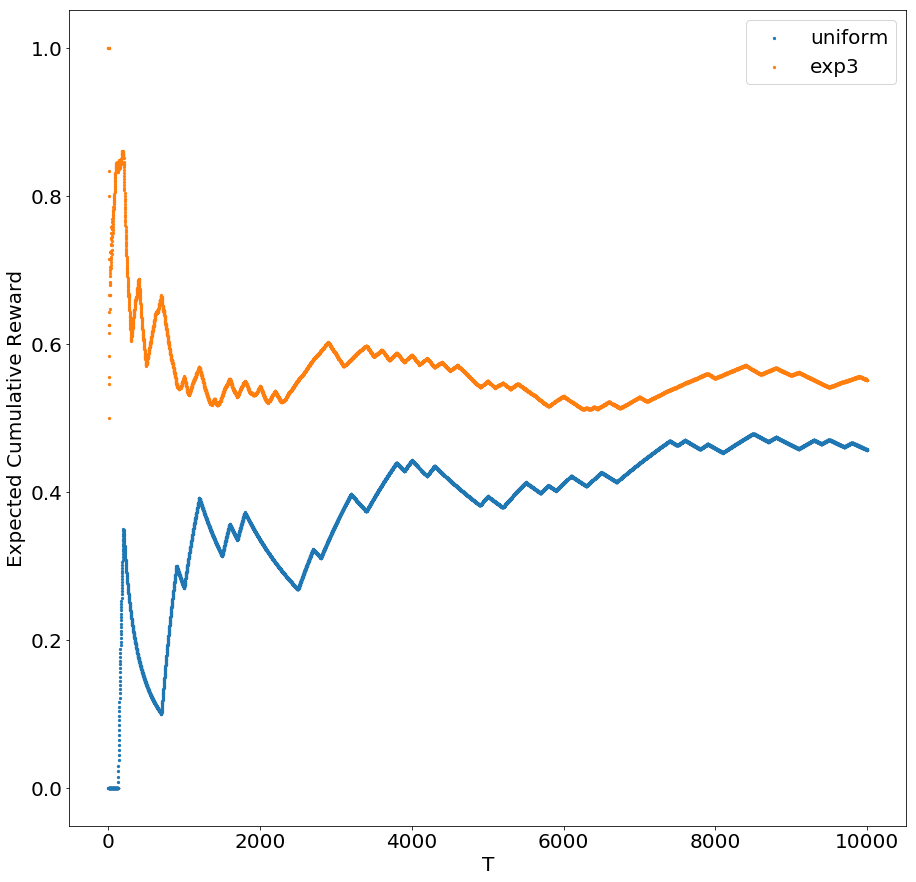

In [168]:
a = np.array(a)
b = np.array(b)
plt.figure(figsize=(15,15))
xplot = range(1,len(b)+1)
ca = np.cumsum(a)
cb = np.cumsum(b)
plt.scatter(xplot,ca/xplot,s=5,label='uniform')
plt.scatter(xplot,cb/xplot,s=5,label='exp3')

plt.legend(fontsize=fs)

plt.xticks(fontsize=fs)
plt.xlabel("T",fontsize=fs)
plt.ylabel('Expected Cumulative Reward',fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('fig7.pdf',bbox_inches='tight')


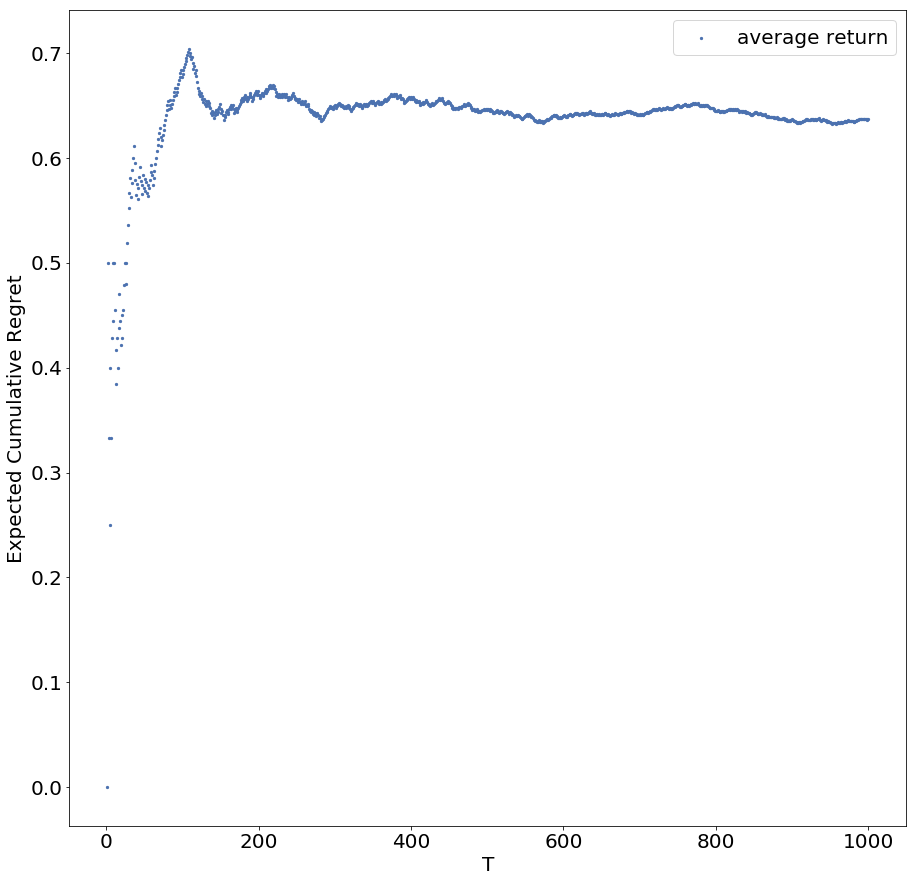

In [56]:
a = np.array(a)

plt.figure(figsize=(15,15))
xplot = range(1,len(a)+1)
cum_reward = np.cumsum(a)
plt.scatter(xplot,cum_reward/xplot,s=5,c ='#4C72B0',label='average return')
plt.legend()
fs = 20    
plt.legend(fontsize=fs)
plt.xticks(fontsize=fs)
plt.xlabel("T",fontsize=fs)
plt.ylabel('Expected Cumulative Regret',fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('fig7.pdf',bbox_inches='tight')

